<a href="https://colab.research.google.com/github/oshbocker/CAFA/blob/main/CAFA_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"oshbocker","key":"bb9c6a60ba5c39e689d8cf8d15cb8bca"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!pip install obonet -q
!pip install biopython -q
!pip install torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 38.2 MB/s eta 0:00:00


In [4]:
import os
import torch

from pathlib import Path


iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

cafa_main_path = Path("cafa-5-protein-function-prediction")
cafa_clean_fasta_path = Path("viktorfairuschin/cafa-5-fasta-files")
esm2_path = Path("viktorfairuschin/cafa-5-ems-2-embeddings-numpy")
protbert_path = Path("henriupton/protbert-embeddings-for-cafa5")
t5_path = Path("sergeifironov/t5embeds")

data_paths = [cafa_clean_fasta_path, esm2_path, protbert_path, t5_path]

if iskaggle:
  content_dir = "/kaggle/input"
else:
  content_dir = "/content"

class CFG:
    train_go_obo_path: str = f"{content_dir}/cafa-5-protein-function-prediction/Train/go-basic.obo"
    train_seq_fasta_path: str = f"{content_dir}/cafa-5-protein-function-prediction/Train/train_sequences.fasta"
    train_terms_path: str = f"{content_dir}/cafa-5-protein-function-prediction/Train/train_terms.tsv"
    train_taxonomy_path: str = f"{content_dir}/cafa-5-protein-function-prediction/Train/train_taxonomy.tsv"
    train_ia_path: str = f"{content_dir}/cafa-5-protein-function-prediction/IA.txt"
    test_sequences_path: str = f"{content_dir}/Test (Targets)/testsuperset.fasta"

    num_labels = 500
    n_epochs = 15
    batch_size = 128
    lr = 0.001

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [5]:
if not iskaggle:
  import zipfile,kaggle
  if not cafa_main_path.exists():
    print(cafa_main_path)
    kaggle.api.competition_download_cli(str(cafa_main_path))
    zipfile.ZipFile(f'{cafa_main_path}.zip').extractall(cafa_main_path)
  for data_path in data_paths:
    if not data_path.exists():
      print(data_path)
      kaggle.api.dataset_download_files(str(data_path))
      zipfile.ZipFile(f'{data_path.name}.zip').extractall(data_path.name)

cafa-5-protein-function-prediction


100%|██████████| 115M/115M [00:07<00:00, 15.7MB/s]



viktorfairuschin/cafa-5-fasta-files
viktorfairuschin/cafa-5-ems-2-embeddings-numpy
henriupton/protbert-embeddings-for-cafa5
sergeifironov/t5embeds


In [6]:
import obonet
import time

import networkx as nx
import pandas as pd
import numpy as np
from Bio import SeqIO
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# TORCH MODULES FOR METRICS COMPUTATION :
import torch
from torch.utils.data import Dataset
from torch import nn
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MultilabelF1Score
from torchmetrics.classification import MultilabelAccuracy

In [7]:
graph = obonet.read_obo(CFG.train_go_obo_path)

In [8]:
# Information Accretion values for terms
ia_dict = {}
with open(CFG.train_ia_path) as f:
    for line in f:
        (key, value) = line.split("\t")
        ia_dict[key] = float(value.replace("\n",""))

In [9]:
subontology_roots = {'BPO':'GO:0008150',
                     'CCO':'GO:0005575',
                     'MFO':'GO:0003674'}

BPO_len = len(nx.ancestors(graph, subontology_roots['BPO']))
CCO_len = len(nx.ancestors(graph, subontology_roots['CCO']))
MFO_len = len(nx.ancestors(graph, subontology_roots['MFO']))
print(BPO_len, CCO_len, MFO_len, BPO_len + CCO_len + MFO_len)

27941 4042 11262 43245


In [10]:
train_terms = pd.read_csv(CFG.train_terms_path, sep="\t")
train_terms['ia'] = train_terms['term'].apply(lambda x: ia_dict[x])
print(train_terms.shape)
train_terms.head(10)

(5363863, 4)


,EntryID,term,aspect,ia
0,A0A009IHW8,GO:0008152,BPO,1.598544
1,A0A009IHW8,GO:0034655,BPO,0.042274
2,A0A009IHW8,GO:0072523,BPO,0.083901
3,A0A009IHW8,GO:0044270,BPO,0.281155
4,A0A009IHW8,GO:0006753,BPO,0.013844
5,A0A009IHW8,GO:1901292,BPO,0.000000
6,A0A009IHW8,GO:0044237,BPO,0.103670
7,A0A009IHW8,GO:1901360,BPO,1.237575
8,A0A009IHW8,GO:0008150,BPO,0.000000
9,A0A009IHW8,GO:1901564,BPO,0.557385


## Get the leaf predictions for each protein
A leaf prediction is a GO term that doesn't have any children that are also predictions for the protein.

In [11]:
def get_leaf_labels(train_terms, aspect):
    # Group by protein and get a list of all go term predictions
    protein_list_go_term = train_terms[train_terms['aspect'] == aspect].groupby('EntryID')['term'].apply(list)

    leaf_labels = {}
    for i, protein in enumerate(protein_list_go_term.index):
        test_terms = set(protein_list_go_term[protein])
        descendants = set()
        for term in test_terms:
            descendants.update(nx.descendants(graph, term))

        specific_labels = test_terms.difference(descendants)
        leaf_labels[protein] = list(specific_labels)

    return leaf_labels

from collections import deque

# Get ordered list of all ancestors
def leaf_label_ancestors(graph, leaf_labels):
    ordered_edges_dict = {}
    for label in leaf_labels:
        # Get ancestors
        ordered_edges = deque()
        node_is_root = False
        prev_node_id = label
        while node_is_root == False:
            node = graph.nodes[prev_node_id]
            node_is_root = 'is_a' not in node
            if not node_is_root:
                prev_node_id = node['is_a'][0]
                ordered_edges.appendleft(prev_node_id)
        ordered_edges_dict[label] = ordered_edges

    return ordered_edges_dict

In [12]:
CCO_leaf_labels = get_leaf_labels(train_terms, 'CCO')
print(len(CCO_leaf_labels.values()))
CCO_all_leaf_labels = np.unique(np.concatenate(list(CCO_leaf_labels.values())))
print(len(CCO_all_leaf_labels))
CCO_nodes = [n for n,v in graph.nodes(data=True) if v['namespace'] == 'cellular_component']
CCO_ordered_edges = leaf_label_ancestors(graph, CCO_nodes)

92912
2763


In [13]:
graph.nodes['GO:0000001']

{'name': 'mitochondrion inheritance',
 'namespace': 'biological_process',
 'def': '"The distribution of mitochondria, including the mitochondrial genome, into daughter cells after mitosis or meiosis, mediated by interactions between mitochondria and the cytoskeleton." [GOC:mcc, PMID:10873824, PMID:11389764]',
 'synonym': ['"mitochondrial inheritance" EXACT []'],
 'is_a': ['GO:0048308', 'GO:0048311']}

In [14]:
# Get the first node label
data_with_labels = []
# Get all CCO labeled proteins with leaf labels
for protein, label_list in CCO_leaf_labels.items():
    for label in label_list:
        data_with_labels.append({'protein': protein,
                                 'label': label,
                                 'ordered_edges': CCO_ordered_edges[label]})

In [15]:
def get_next_label(rw, depth=1):
    if not rw['labeled'] and len(rw['ordered_edges']) > depth:
        return rw['ordered_edges'][-depth]
    else:
        return rw['balanced_label']

def is_final_balanced_label(rw, balanced_labels, depth=1):
    if not rw['labeled']:
        return (rw['balanced_label'] in balanced_labels) or (len(rw['ordered_edges']) == depth)
    else:
        return True

def get_balanced_labels(label_df, label_count_threshold):
    df = label_df.copy()
    balanced_labels = set([label for label, count in df['label'].value_counts().items()
                           if count >= label_count_threshold])
    df['labeled'] = df['label'].apply(lambda x: x in balanced_labels)
    df['balanced_label'] = df['label'] # df.apply(lambda x: x['label'] if x['labeled'] == True else None, axis=1)
    print(sum(df['labeled'])/df.shape[0])
    print(len(balanced_labels))
    print(df['balanced_label'].value_counts())
    depth = 1
    while sum(df['labeled'])/df.shape[0] < 1:
        df['balanced_label'] = df.apply(lambda x: get_next_label(x, depth=depth), axis=1)
        balanced_labels = set([label for label, count in df['balanced_label'].value_counts().items()
                                   if count >= label_count_threshold])
        df['labeled'] = df.apply(lambda x: is_final_balanced_label(x, balanced_labels, depth=depth), axis=1)
        depth += 1
        print(sum(df['labeled'])/df.shape[0])
        print(len(balanced_labels))
        print(df['balanced_label'].value_counts())

    return df

In [16]:
CCO_df = pd.DataFrame(data_with_labels)

new_CCO_df = get_balanced_labels(CCO_df, 1358)

0.46988094968653105
14
GO:0005829    16981
GO:0005634    12661
GO:0005886    11509
GO:0005737     8335
GO:0005654     8160
              ...  
GO:1990332        1
GO:0009316        1
GO:0099571        1
GO:0044186        1
GO:0071202        1
Name: balanced_label, Length: 2763, dtype: int64
0.6748296856256931
26
GO:0005829    16981
GO:0110165    12989
GO:0005634    12725
GO:0005886    11823
GO:0005737     8932
              ...  
GO:0032160        1
GO:0055035        1
GO:0031002        1
GO:0030929        1
GO:0098539        1
Name: balanced_label, Length: 678, dtype: int64
0.8399723875698798
29
GO:0110165    21336
GO:0005829    17050
GO:0005634    12910
GO:0005886    11823
GO:0005737     8948
              ...  
GO:0099572        1
GO:0033176        1
GO:0097518        1
GO:0005788        1
GO:0042170        1
Name: balanced_label, Length: 272, dtype: int64
0.9202521331733925
29
GO:0110165    25516
GO:0005829    17050
GO:0005634    12938
GO:0005886    11823
GO:0032991    10919
      

## Classify selected nodes of CCO

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
ohe_CCO_df = pd.get_dummies(new_CCO_df, prefix=['balanced_label'], columns=['balanced_label'], drop_first=True)
label_cols = [c for c in ohe_CCO_df.columns if 'balanced_label_' in c]
label_df = ohe_CCO_df.groupby('protein').sum(numeric_only=True)[label_cols].clip(0,1)
label_values = list(label_df.values)
label_ids = list(label_df.index)
labels_df = pd.DataFrame(data={"EntryID": label_ids, "labels_vect": label_values})

# Split into train, val, test
X_train, X_test, y_train, y_test = train_test_split(label_ids,
                                                    label_values,
                                                    test_size = 0.2)
print("Train label", len(y_train))
print("Test label", len(y_test))

Train label 74329
Test label 18583


In [19]:
# Directories for the different embedding vectors :
embeds_map = {
    "T5" : "t5embeds",
    "ProtBERT" : "protbert-embeddings-for-cafa5",
    "ESM2" : "cafa-5-ems-2-embeddings-numpy"
}

# Length of the different embedding vectors :
embeds_dim = {
    "T5" : 1024,
    "ProtBERT" : 1024,
    "ESM2" : 1280,
    "Concat": 1024+1024,
}

In [20]:
class ProteinSequenceDataset(Dataset):

    def __init__(self, datatype, embeddings_source):
        super(ProteinSequenceDataset).__init__()
        self.datatype = datatype

        if embeddings_source in ["ProtBERT", "ESM2"]:
            embeds = np.load(f"{content_dir}/"+embeds_map[embeddings_source]+"/"+datatype+"_embeddings.npy")
            ids = np.load(f"{content_dir}/"+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")

        if embeddings_source == "T5":
            embeds = np.load(f"{content_dir}/"+embeds_map[embeddings_source]+"/"+datatype+"_embeds.npy")
            ids = np.load(f"{content_dir}/"+embeds_map[embeddings_source]+"/"+datatype+"_ids.npy")

        if embeddings_source == "Concat":
            bert_embeds = np.load(f"{content_dir}/"+embeds_map["ProtBERT"]+"/"+datatype+"_embeddings.npy")
            bert_ids = np.load(f"{content_dir}/"+embeds_map["ProtBERT"]+"/"+datatype+"_ids.npy")
            esm2_embeds = np.load(f"{content_dir}/"+embeds_map["ESM2"]+"/"+datatype+"_embeddings.npy")
            esm2_ids = np.load(f"{content_dir}/"+embeds_map["ESM2"]+"/"+datatype+"_ids.npy")
            t5_embeds = np.load(f"{content_dir}/"+embeds_map["T5"]+"/"+datatype+"_embeds.npy")
            t5_ids = np.load(f"{content_dir}/"+embeds_map["T5"]+"/"+datatype+"_ids.npy")
            embeds = np.concatenate([bert_embeds, t5_embeds], axis=1)
            embeds_list = []
            for l in range(embeds.shape[0]):
                embeds_list.append(embeds[l,:])
            self.df = pd.DataFrame(data={"EntryID": t5_ids, "embed" : embeds_list})
        else:
            embeds_list = []
            for l in range(embeds.shape[0]):
                embeds_list.append(embeds[l,:])
            self.df = pd.DataFrame(data={"EntryID": ids, "embed" : embeds_list})


        if datatype=="train":
            self.df = self.df.merge(labels_df, on="EntryID")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        embed = torch.tensor(self.df.iloc[index]["embed"] , dtype = torch.float32)
        if self.datatype=="train":
            targets = torch.tensor(self.df.iloc[index]["labels_vect"], dtype = torch.float32)
            return embed, targets
        if self.datatype=="test":
            id = self.df.iloc[index]["EntryID"]
            return embed, id

In [21]:
datatype = "train"
bert_embeds = np.load(f"{content_dir}/"+embeds_map["ProtBERT"]+"/"+datatype+"_embeddings.npy")
bert_ids = np.load(f"{content_dir}/"+embeds_map["ProtBERT"]+"/"+datatype+"_ids.npy")
esm2_embeds = np.load(f"{content_dir}/"+embeds_map["ESM2"]+"/"+datatype+"_embeddings.npy")
esm2_ids = np.load(f"{content_dir}/"+embeds_map["ESM2"]+"/"+datatype+"_ids.npy")
t5_embeds = np.load(f"{content_dir}/"+embeds_map["T5"]+"/"+datatype+"_embeds.npy")
t5_ids = np.load(f"{content_dir}/"+embeds_map["T5"]+"/"+datatype+"_ids.npy")

In [22]:
bert_embeds.shape

(142246, 1024)

In [23]:
np.concatenate([bert_embeds, t5_embeds], axis=1).shape

(142246, 2048)

In [24]:
print(bert_ids[:5])
print(esm2_ids[:5])
print(t5_ids[:5])

['P20536' 'O73864' 'O95231' 'A0A0B4J1F4' 'P54366']
['Q9ZSA8' 'P25353' 'A0A2R8YCW8' 'G3V5N8' 'A0A140LFN4']
['P20536' 'O73864' 'O95231' 'A0A0B4J1F4' 'P54366']


In [25]:
class MultiLayerPerceptron(torch.nn.Module):

    def __init__(self, input_dim, num_classes):
        super(MultiLayerPerceptron, self).__init__()

        self.linear1 = torch.nn.Linear(input_dim, 4*1012)
        self.activation1 = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(4*1012, 4*712)
        self.activation2 = torch.nn.ReLU()
        self.linear3 = torch.nn.Linear(4*712, num_classes)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
        return x


class CNN1D(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CNN1D, self).__init__()
        # (batch_size, channels, embed_size)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=3, kernel_size=3, dilation=1, padding=1, stride=1)
        # (batch_size, 3, embed_size)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        # (batch_size, 3, embed_size/2 = 512)
        self.conv2 = nn.Conv1d(in_channels=3, out_channels=8, kernel_size=3, dilation=1, padding=1, stride=1)
        # (batch_size, 8, embed_size/2 = 512)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        # (batch_size, 8, embed_size/4 = 256)
        self.fc1 = nn.Linear(in_features=int(8 * input_dim/4), out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [26]:
def train_model(embeddings_source, model_type="linear", train_size=0.9):

    train_dataset = ProteinSequenceDataset(datatype="train", embeddings_source = embeddings_source)

    train_set, val_set = random_split(train_dataset, lengths = [int(len(train_dataset)*train_size), len(train_dataset)-int(len(train_dataset)*train_size)])
    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=CFG.batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=CFG.batch_size, shuffle=True)

    if model_type == "linear":
        model = MultiLayerPerceptron(input_dim=embeds_dim[embeddings_source], num_classes=CFG.num_labels).to(CFG.device)
    if model_type == "convolutional":
        model = CNN1D(input_dim=embeds_dim[embeddings_source], num_classes=CFG.num_labels).to(CFG.device)

    optimizer = torch.optim.Adam(model.parameters(), lr = CFG.lr)
    scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=1)
    CrossEntropy = torch.nn.CrossEntropyLoss()
    f1_score = MultilabelF1Score(num_labels=CFG.num_labels).to(CFG.device)
    n_epochs = CFG.n_epochs

    print("BEGIN TRAINING...")
    train_loss_history=[]
    val_loss_history=[]

    train_f1score_history=[]
    val_f1score_history=[]
    for epoch in range(n_epochs):
        print("EPOCH ", epoch+1)
        ## TRAIN PHASE :
        losses = []
        scores = []
        for embed, targets in tqdm(train_dataloader):
            embed, targets = embed.to(CFG.device), targets.to(CFG.device)
            optimizer.zero_grad()
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item())
            scores.append(score.item())
            loss.backward()
            optimizer.step()
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average TRAIN Loss : ", avg_loss)
        print("Running Average TRAIN F1-Score : ", avg_score)
        train_loss_history.append(avg_loss)
        train_f1score_history.append(avg_score)

        ## VALIDATION PHASE :
        losses = []
        scores = []
        for embed, targets in val_dataloader:
            embed, targets = embed.to(CFG.device), targets.to(CFG.device)
            preds = model(embed)
            loss= CrossEntropy(preds, targets)
            score=f1_score(preds, targets)
            losses.append(loss.item())
            scores.append(score.item())
        avg_loss = np.mean(losses)
        avg_score = np.mean(scores)
        print("Running Average VAL Loss : ", avg_loss)
        print("Running Average VAL F1-Score : ", avg_score)
        val_loss_history.append(avg_loss)
        val_f1score_history.append(avg_score)

        scheduler.step(avg_loss)
        print("\n")

    print("TRAINING FINISHED")
    print("FINAL TRAINING SCORE : ", train_f1score_history[-1])
    print("FINAL VALIDATION SCORE : ", val_f1score_history[-1])

    losses_history = {"train" : train_loss_history, "val" : val_loss_history}
    scores_history = {"train" : train_f1score_history, "val" : val_f1score_history}

    return model, losses_history, scores_history

In [27]:
train_dataset = ProteinSequenceDataset(datatype="train", embeddings_source = "ESM2")
CFG.num_labels = train_dataset[0][1].shape[0]

In [28]:
cat_model, cat_losses,cat_scores = train_model(embeddings_source="Concat",model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 654/654 [00:16<00:00, 39.40it/s]


Running Average TRAIN Loss :  4.30169092843292
Running Average TRAIN F1-Score :  0.1889490393255282
Running Average VAL Loss :  4.103079416980482
Running Average VAL F1-Score :  0.20986565988357753


EPOCH  2


100%|██████████| 654/654 [00:13<00:00, 47.89it/s]


Running Average TRAIN Loss :  4.033902499653878
Running Average TRAIN F1-Score :  0.22452347857780777
Running Average VAL Loss :  3.9708605531143815
Running Average VAL F1-Score :  0.22238785987847473


EPOCH  3


100%|██████████| 654/654 [00:13<00:00, 48.31it/s]


Running Average TRAIN Loss :  3.9207509890973387
Running Average TRAIN F1-Score :  0.2399654848449821
Running Average VAL Loss :  3.923627784807388
Running Average VAL F1-Score :  0.24115504610211883


EPOCH  4


100%|██████████| 654/654 [00:13<00:00, 47.99it/s]


Running Average TRAIN Loss :  3.8266090894693265
Running Average TRAIN F1-Score :  0.2516456075263315
Running Average VAL Loss :  3.8894156658486145
Running Average VAL F1-Score :  0.24621668070146482


EPOCH  5


100%|██████████| 654/654 [00:14<00:00, 46.24it/s]


Running Average TRAIN Loss :  3.7365559776988597
Running Average TRAIN F1-Score :  0.26440984580312665
Running Average VAL Loss :  3.843437959070075
Running Average VAL F1-Score :  0.2490933706907377


EPOCH  6


100%|██████████| 654/654 [00:13<00:00, 46.75it/s]


Running Average TRAIN Loss :  3.645634442658964
Running Average TRAIN F1-Score :  0.2765117310192607
Running Average VAL Loss :  3.832031687645063
Running Average VAL F1-Score :  0.2601083398681797


EPOCH  7


100%|██████████| 654/654 [00:14<00:00, 46.37it/s]


Running Average TRAIN Loss :  3.5520782244679396
Running Average TRAIN F1-Score :  0.28867905910499964
Running Average VAL Loss :  3.8597992642285073
Running Average VAL F1-Score :  0.26902275665165626


EPOCH  8


100%|██████████| 654/654 [00:14<00:00, 46.34it/s]


Running Average TRAIN Loss :  3.461721529654407
Running Average TRAIN F1-Score :  0.3007661062734207
Running Average VAL Loss :  3.8038092769988596
Running Average VAL F1-Score :  0.27739147943993137


EPOCH  9


100%|██████████| 654/654 [00:13<00:00, 46.92it/s]


Running Average TRAIN Loss :  3.366000982599521
Running Average TRAIN F1-Score :  0.31482350639429296
Running Average VAL Loss :  3.842307045035166
Running Average VAL F1-Score :  0.2794368899848363


EPOCH  10


100%|██████████| 654/654 [00:13<00:00, 47.53it/s]


Running Average TRAIN Loss :  3.269770879628826
Running Average TRAIN F1-Score :  0.3274562275692228
Running Average VAL Loss :  3.856898278406222
Running Average VAL F1-Score :  0.2872881379029522


EPOCH  11


100%|██████████| 654/654 [00:13<00:00, 47.06it/s]


Running Average TRAIN Loss :  2.9916001226559326
Running Average TRAIN F1-Score :  0.35137332046250686
Running Average VAL Loss :  3.816302769804654
Running Average VAL F1-Score :  0.2961813560495638


EPOCH  12


100%|██████████| 654/654 [00:13<00:00, 47.43it/s]


Running Average TRAIN Loss :  2.9167257306772636
Running Average TRAIN F1-Score :  0.35776843759444876
Running Average VAL Loss :  3.842448296612256
Running Average VAL F1-Score :  0.29967141069778025


EPOCH  13


100%|██████████| 654/654 [00:13<00:00, 46.94it/s]


Running Average TRAIN Loss :  2.8613213661613814
Running Average TRAIN F1-Score :  0.36281526881620424
Running Average VAL Loss :  3.8407474674590647
Running Average VAL F1-Score :  0.2984908535464169


EPOCH  14


100%|██████████| 654/654 [00:13<00:00, 48.44it/s]


Running Average TRAIN Loss :  2.8549812350433537
Running Average TRAIN F1-Score :  0.3628040819631075
Running Average VAL Loss :  3.847822522463864
Running Average VAL F1-Score :  0.29840583180728025


EPOCH  15


100%|██████████| 654/654 [00:13<00:00, 47.68it/s]


Running Average TRAIN Loss :  2.847251395566748
Running Average TRAIN F1-Score :  0.36384478922283975
Running Average VAL Loss :  3.8469613218960697
Running Average VAL F1-Score :  0.3014106201390698


TRAINING FINISHED
FINAL TRAINING SCORE :  0.36384478922283975
FINAL VALIDATION SCORE :  0.3014106201390698


In [29]:
esm2_model, esm2_losses, esm2_scores = train_model(embeddings_source="ESM2",model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 654/654 [00:12<00:00, 52.39it/s]


Running Average TRAIN Loss :  4.296176616569542
Running Average TRAIN F1-Score :  0.19399657177906882
Running Average VAL Loss :  4.156033127275232
Running Average VAL F1-Score :  0.2169266792192851


EPOCH  2


100%|██████████| 654/654 [00:12<00:00, 51.73it/s]


Running Average TRAIN Loss :  4.034048943344606
Running Average TRAIN F1-Score :  0.22925645090206684
Running Average VAL Loss :  4.061596008196269
Running Average VAL F1-Score :  0.23366681129148562


EPOCH  3


100%|██████████| 654/654 [00:12<00:00, 52.05it/s]


Running Average TRAIN Loss :  3.9046436238361792
Running Average TRAIN F1-Score :  0.2462356239785113
Running Average VAL Loss :  3.9862237858445675
Running Average VAL F1-Score :  0.24618555829949576


EPOCH  4


100%|██████████| 654/654 [00:12<00:00, 52.19it/s]


Running Average TRAIN Loss :  3.7837900411827485
Running Average TRAIN F1-Score :  0.26207987002641053
Running Average VAL Loss :  3.9457636630698425
Running Average VAL F1-Score :  0.25489175482972026


EPOCH  5


100%|██████████| 654/654 [00:12<00:00, 52.80it/s]


Running Average TRAIN Loss :  3.6636265414205895
Running Average TRAIN F1-Score :  0.2784776467066657
Running Average VAL Loss :  3.9384305019901222
Running Average VAL F1-Score :  0.2634311414336505


EPOCH  6


100%|██████████| 654/654 [00:12<00:00, 51.78it/s]


Running Average TRAIN Loss :  3.5346593546940284
Running Average TRAIN F1-Score :  0.2946227259182055
Running Average VAL Loss :  3.89642002157969
Running Average VAL F1-Score :  0.27544117280065195


EPOCH  7


100%|██████████| 654/654 [00:12<00:00, 52.49it/s]


Running Average TRAIN Loss :  3.402657754559765
Running Average TRAIN F1-Score :  0.31338527987765247
Running Average VAL Loss :  3.9046233386209566
Running Average VAL F1-Score :  0.2808048343413497


EPOCH  8


100%|██████████| 654/654 [00:12<00:00, 52.76it/s]


Running Average TRAIN Loss :  3.267142102259015
Running Average TRAIN F1-Score :  0.3313377294062839
Running Average VAL Loss :  3.896822063890222
Running Average VAL F1-Score :  0.2945119222141292


EPOCH  9


100%|██████████| 654/654 [00:12<00:00, 52.26it/s]


Running Average TRAIN Loss :  2.9165146321696245
Running Average TRAIN F1-Score :  0.3612262304040635
Running Average VAL Loss :  3.8992465914112246
Running Average VAL F1-Score :  0.3009430384390975


EPOCH  10


100%|██████████| 654/654 [00:12<00:00, 52.03it/s]


Running Average TRAIN Loss :  2.820667920127192
Running Average TRAIN F1-Score :  0.3709218106958844
Running Average VAL Loss :  3.9015828844619125
Running Average VAL F1-Score :  0.3024213440614204


EPOCH  11


100%|██████████| 654/654 [00:12<00:00, 52.69it/s]


Running Average TRAIN Loss :  2.7491066993558806
Running Average TRAIN F1-Score :  0.3787525036921924
Running Average VAL Loss :  3.9085642115710533
Running Average VAL F1-Score :  0.30419607582974106


EPOCH  12


100%|██████████| 654/654 [00:12<00:00, 52.72it/s]


Running Average TRAIN Loss :  2.739822334105815
Running Average TRAIN F1-Score :  0.37942093018362644
Running Average VAL Loss :  3.917344677938174
Running Average VAL F1-Score :  0.30511362054576613


EPOCH  13


100%|██████████| 654/654 [00:12<00:00, 52.42it/s]


Running Average TRAIN Loss :  2.7311179382720856
Running Average TRAIN F1-Score :  0.38017779661610224
Running Average VAL Loss :  3.9169883956647897
Running Average VAL F1-Score :  0.30652832699148624


EPOCH  14


100%|██████████| 654/654 [00:12<00:00, 52.93it/s]


Running Average TRAIN Loss :  2.7307684567361066
Running Average TRAIN F1-Score :  0.3812217038432392
Running Average VAL Loss :  3.9170794748280144
Running Average VAL F1-Score :  0.30450814962387085


EPOCH  15


100%|██████████| 654/654 [00:12<00:00, 52.20it/s]


Running Average TRAIN Loss :  2.729771591472334
Running Average TRAIN F1-Score :  0.3805014941305925
Running Average VAL Loss :  3.916634393064943
Running Average VAL F1-Score :  0.30318297547836826


TRAINING FINISHED
FINAL TRAINING SCORE :  0.3805014941305925
FINAL VALIDATION SCORE :  0.30318297547836826


In [30]:
# Weighted F1 Score?

In [31]:
t5_model, t5_losses, t5_scores = train_model(embeddings_source="T5",model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 654/654 [00:13<00:00, 48.29it/s]


Running Average TRAIN Loss :  4.1727093811793425
Running Average TRAIN F1-Score :  0.20372711680259908
Running Average VAL Loss :  3.992551712140645
Running Average VAL F1-Score :  0.22545042981023658


EPOCH  2


100%|██████████| 654/654 [00:13<00:00, 48.50it/s]


Running Average TRAIN Loss :  3.871548890338396
Running Average TRAIN F1-Score :  0.24281156552949812
Running Average VAL Loss :  3.8588907228757257
Running Average VAL F1-Score :  0.24105007293289654


EPOCH  3


100%|██████████| 654/654 [00:13<00:00, 48.30it/s]


Running Average TRAIN Loss :  3.681215969065278
Running Average TRAIN F1-Score :  0.26683716817733344
Running Average VAL Loss :  3.7975370230740064
Running Average VAL F1-Score :  0.25606727640922755


EPOCH  4


100%|██████████| 654/654 [00:13<00:00, 47.97it/s]


Running Average TRAIN Loss :  3.489656923378644
Running Average TRAIN F1-Score :  0.2896629549585716
Running Average VAL Loss :  3.770350593410126
Running Average VAL F1-Score :  0.27025477179925733


EPOCH  5


100%|██████████| 654/654 [00:13<00:00, 49.28it/s]


Running Average TRAIN Loss :  3.2939773382396873
Running Average TRAIN F1-Score :  0.31195235753642675
Running Average VAL Loss :  3.779873015129403
Running Average VAL F1-Score :  0.28388329483058355


EPOCH  6


100%|██████████| 654/654 [00:13<00:00, 48.07it/s]


Running Average TRAIN Loss :  3.103117217346798
Running Average TRAIN F1-Score :  0.33640485897158995
Running Average VAL Loss :  3.807657156905083
Running Average VAL F1-Score :  0.293620838490251


EPOCH  7


100%|██████████| 654/654 [00:13<00:00, 48.89it/s]


Running Average TRAIN Loss :  2.706022516303106
Running Average TRAIN F1-Score :  0.3687949285412418
Running Average VAL Loss :  3.8346664415646905
Running Average VAL F1-Score :  0.30873467762992807


EPOCH  8


100%|██████████| 654/654 [00:13<00:00, 47.88it/s]


Running Average TRAIN Loss :  2.5838336414153424
Running Average TRAIN F1-Score :  0.3820135995335535
Running Average VAL Loss :  3.8765082849215156
Running Average VAL F1-Score :  0.3119549294040628


EPOCH  9


100%|██████████| 654/654 [00:13<00:00, 47.95it/s]


Running Average TRAIN Loss :  2.4940948205621236
Running Average TRAIN F1-Score :  0.3910818562959677
Running Average VAL Loss :  3.914780989085158
Running Average VAL F1-Score :  0.31405699293907374


EPOCH  10


100%|██████████| 654/654 [00:13<00:00, 49.22it/s]


Running Average TRAIN Loss :  2.4831861199224394
Running Average TRAIN F1-Score :  0.39268842180023134
Running Average VAL Loss :  3.9192299189632887
Running Average VAL F1-Score :  0.31426139849506013


EPOCH  11


100%|██████████| 654/654 [00:12<00:00, 50.57it/s]


Running Average TRAIN Loss :  2.4729000450274268
Running Average TRAIN F1-Score :  0.39334656717398114
Running Average VAL Loss :  3.9226530088137275
Running Average VAL F1-Score :  0.31403410842973895


EPOCH  12


100%|██████████| 654/654 [00:13<00:00, 48.12it/s]


Running Average TRAIN Loss :  2.472246291805116
Running Average TRAIN F1-Score :  0.3946318836933976
Running Average VAL Loss :  3.9288328347140795
Running Average VAL F1-Score :  0.31426188063948124


EPOCH  13


100%|██████████| 654/654 [00:13<00:00, 48.47it/s]


Running Average TRAIN Loss :  2.470559235924245
Running Average TRAIN F1-Score :  0.39372627883693856
Running Average VAL Loss :  3.9223191640148425
Running Average VAL F1-Score :  0.3159299276462973


EPOCH  14


100%|██████████| 654/654 [00:13<00:00, 48.24it/s]


Running Average TRAIN Loss :  2.4705880118437133
Running Average TRAIN F1-Score :  0.39309270930581863
Running Average VAL Loss :  3.9196829991797877
Running Average VAL F1-Score :  0.31554466975878365


EPOCH  15


100%|██████████| 654/654 [00:13<00:00, 48.78it/s]


Running Average TRAIN Loss :  2.470989865265126
Running Average TRAIN F1-Score :  0.39371224048487635
Running Average VAL Loss :  3.9274638744249737
Running Average VAL F1-Score :  0.3141600252830819


TRAINING FINISHED
FINAL TRAINING SCORE :  0.39371224048487635
FINAL VALIDATION SCORE :  0.3141600252830819


In [32]:
protbert_model, protbert_losses, protbert_scores = train_model(embeddings_source="T5",model_type="linear")

BEGIN TRAINING...
EPOCH  1


100%|██████████| 654/654 [00:13<00:00, 48.24it/s]


Running Average TRAIN Loss :  4.165585340345307
Running Average TRAIN F1-Score :  0.20382051442148852
Running Average VAL Loss :  4.0556814997163535
Running Average VAL F1-Score :  0.2316154760040649


EPOCH  2


100%|██████████| 654/654 [00:13<00:00, 49.72it/s]


Running Average TRAIN Loss :  3.863043064735716
Running Average TRAIN F1-Score :  0.24302400067585325
Running Average VAL Loss :  3.9255108082131165
Running Average VAL F1-Score :  0.24766041889582593


EPOCH  3


100%|██████████| 654/654 [00:13<00:00, 48.49it/s]


Running Average TRAIN Loss :  3.673370156448551
Running Average TRAIN F1-Score :  0.2661111918292279
Running Average VAL Loss :  3.84974623379642
Running Average VAL F1-Score :  0.2654753121202939


EPOCH  4


100%|██████████| 654/654 [00:13<00:00, 47.60it/s]


Running Average TRAIN Loss :  3.48045401726294
Running Average TRAIN F1-Score :  0.29001277616811455
Running Average VAL Loss :  3.8106006432885993
Running Average VAL F1-Score :  0.2791578471660614


EPOCH  5


100%|██████████| 654/654 [00:13<00:00, 48.09it/s]


Running Average TRAIN Loss :  3.282890927900962
Running Average TRAIN F1-Score :  0.31278595592632935
Running Average VAL Loss :  3.818926406233278
Running Average VAL F1-Score :  0.28465061930760943


EPOCH  6


100%|██████████| 654/654 [00:13<00:00, 48.52it/s]


Running Average TRAIN Loss :  3.0899919442809685
Running Average TRAIN F1-Score :  0.3361241019555917
Running Average VAL Loss :  3.858202924467113
Running Average VAL F1-Score :  0.2982659262337097


EPOCH  7


100%|██████████| 654/654 [00:13<00:00, 48.51it/s]


Running Average TRAIN Loss :  2.6909699558482623
Running Average TRAIN F1-Score :  0.3700725831752159
Running Average VAL Loss :  3.881934691781867
Running Average VAL F1-Score :  0.3097008127872258


EPOCH  8


100%|██████████| 654/654 [00:13<00:00, 47.05it/s]


Running Average TRAIN Loss :  2.567834773924008
Running Average TRAIN F1-Score :  0.38292432651607267
Running Average VAL Loss :  3.9270316542011416
Running Average VAL F1-Score :  0.3164827329655216


EPOCH  9


100%|██████████| 654/654 [00:13<00:00, 46.78it/s]


Running Average TRAIN Loss :  2.4794026813740393
Running Average TRAIN F1-Score :  0.39243823276200424
Running Average VAL Loss :  3.9555672717421024
Running Average VAL F1-Score :  0.31848572990665697


EPOCH  10


100%|██████████| 654/654 [00:13<00:00, 48.06it/s]


Running Average TRAIN Loss :  2.4681954010181837
Running Average TRAIN F1-Score :  0.3939020379420814
Running Average VAL Loss :  3.9607422449817395
Running Average VAL F1-Score :  0.31821973029881306


EPOCH  11


100%|██████████| 654/654 [00:13<00:00, 48.33it/s]


Running Average TRAIN Loss :  2.456712278568781
Running Average TRAIN F1-Score :  0.39478586213122085
Running Average VAL Loss :  3.967636526447453
Running Average VAL F1-Score :  0.3196690723504106


EPOCH  12


100%|██████████| 654/654 [00:13<00:00, 49.10it/s]


Running Average TRAIN Loss :  2.456894441482124
Running Average TRAIN F1-Score :  0.3953939213756392
Running Average VAL Loss :  3.96445290683067
Running Average VAL F1-Score :  0.3200668943663166


EPOCH  13


100%|██████████| 654/654 [00:13<00:00, 48.79it/s]


Running Average TRAIN Loss :  2.455391075997542
Running Average TRAIN F1-Score :  0.3958772041290907
Running Average VAL Loss :  3.969772218024894
Running Average VAL F1-Score :  0.31912881421716244


EPOCH  14


100%|██████████| 654/654 [00:13<00:00, 48.62it/s]


Running Average TRAIN Loss :  2.4549161494689615
Running Average TRAIN F1-Score :  0.395369091301883
Running Average VAL Loss :  3.9655438188004166
Running Average VAL F1-Score :  0.31886712084077806


EPOCH  15


100%|██████████| 654/654 [00:13<00:00, 48.16it/s]


Running Average TRAIN Loss :  2.4558892359427356
Running Average TRAIN F1-Score :  0.3953366469626033
Running Average VAL Loss :  3.966418452458839
Running Average VAL F1-Score :  0.3216650024668811


TRAINING FINISHED
FINAL TRAINING SCORE :  0.3953366469626033
FINAL VALIDATION SCORE :  0.3216650024668811


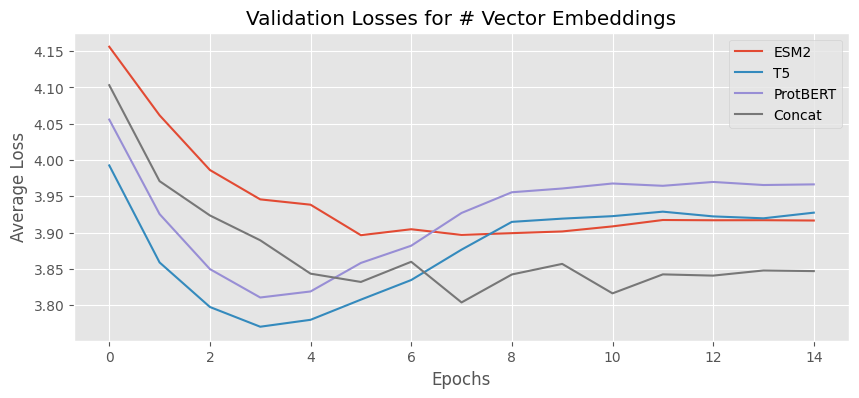

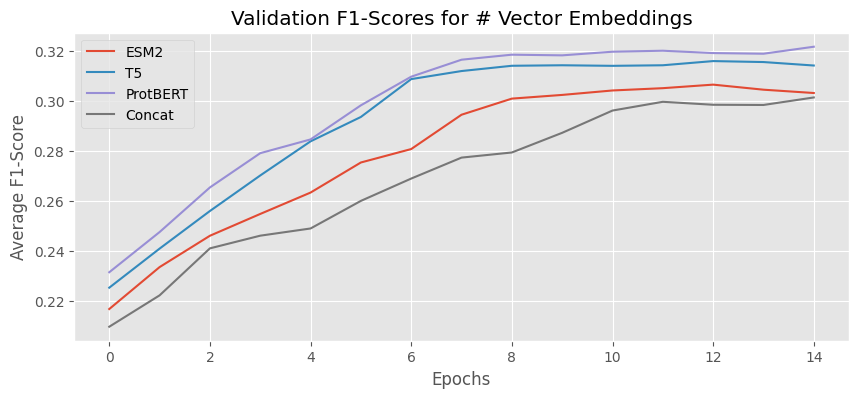

In [43]:
plt.figure(figsize = (10, 4))
plt.plot(esm2_losses["val"], label = "ESM2")
plt.plot(t5_losses["val"], label = "T5")
plt.plot(protbert_losses["val"], label = "ProtBERT")
plt.plot(cat_losses["val"], label = "Concat")
plt.title("Validation Losses for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average Loss")
plt.legend()
plt.show()

plt.figure(figsize = (10, 4))
plt.plot(esm2_scores["val"], label = "ESM2")
plt.plot(t5_scores["val"], label = "T5")
plt.plot(protbert_scores["val"], label = "ProtBERT")
plt.plot(cat_scores["val"], label = "Concat")
plt.title("Validation F1-Scores for # Vector Embeddings")
plt.xlabel("Epochs")
plt.ylabel("Average F1-Score")
plt.legend()
plt.show()

## Make Predictions

In [34]:
def predict(embeddings_source):

    test_dataset = ProteinSequenceDataset(datatype="test", embeddings_source = embeddings_source)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

    if embeddings_source == "T5":
        model = t5_model
    if embeddings_source == "ProtBERT":
        model = protbert_model
    if embeddings_source == "EMS2":
        model = esm2_model
    if embeddings_source == "Concat":
        model = cat_model

    model.eval()

    labels = pd.read_csv(CFG.train_terms_path, sep = "\t")
    top_terms = labels.groupby("term")["EntryID"].count().sort_values(ascending=False)
    labels_names = [label.split('_')[-1] for label in label_cols]
    print("GENERATE PREDICTION FOR TEST SET...")

    ids_ = np.empty(shape=(len(test_dataloader)*CFG.num_labels,), dtype=object)
    go_terms_ = np.empty(shape=(len(test_dataloader)*CFG.num_labels,), dtype=object)
    confs_ = np.empty(shape=(len(test_dataloader)*CFG.num_labels,), dtype=np.float32)

    for i, (embed, id) in tqdm(enumerate(test_dataloader)):
        embed = embed.to(CFG.device)
        confs_[i*CFG.num_labels:(i+1)*CFG.num_labels] = torch.nn.functional.sigmoid(model(embed)).squeeze().detach().cpu().numpy()
        ids_[i*CFG.num_labels:(i+1)*CFG.num_labels] = id[0]
        go_terms_[i*CFG.num_labels:(i+1)*CFG.num_labels] = labels_names

    submission_df = pd.DataFrame(data={"Id" : ids_, "GO term" : go_terms_, "Confidence" : confs_})
    print("PREDICTIONS DONE")
    return submission_df

In [35]:
submission_df = predict("Concat")

GENERATE PREDICTION FOR TEST SET...


141865it [01:47, 1315.72it/s]


PREDICTIONS DONE


In [36]:
print(len(submission_df))
print(len(submission_df["GO term"].unique()))
submission_df.head()

4114085
29


,Id,GO term,Confidence
0,Q9CQV8,GO:0005615,0.253148
1,Q9CQV8,GO:0005634,0.780635
2,Q9CQV8,GO:0005654,0.350068
3,Q9CQV8,GO:0005730,0.013435
4,Q9CQV8,GO:0005737,0.420651


In [37]:
id_list = []
go_term_list = []
confidence_list = []
for rw in submission_df.values:
  edges = CCO_ordered_edges[rw[1]]
  for edge in edges:
    id_list.append(rw[0])
    go_term_list.append(edge)
    confidence_list.append(rw[2])

In [38]:
additional_labels = pd.DataFrame({'Id': id_list, 'GO term': go_term_list, 'Confidence': confidence_list})

In [39]:
submission_df = pd.concat([submission_df, additional_labels]).drop_duplicates()

In [40]:
print(len(submission_df))
print(len(submission_df["GO term"].unique()))
submission_df.head()

17165539
41


,Id,GO term,Confidence
0,Q9CQV8,GO:0005615,0.253148
1,Q9CQV8,GO:0005634,0.780635
2,Q9CQV8,GO:0005654,0.350068
3,Q9CQV8,GO:0005730,0.013435
4,Q9CQV8,GO:0005737,0.420651


In [41]:
submission_df.to_csv('submission.tsv', sep='\t', index=False)